In the twitter Datasets, target column is the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

In [1]:
! pip install -q "tensorflow==2.16.1" "gdown==4.6"

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle

In [4]:
!gdown --id 19TGf1A2MwlBlYM1ORKJREjP77Y1dGoB7

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19TGf1A2MwlBlYM1ORKJREjP77Y1dGoB7
From (redirected): https://drive.google.com/uc?id=19TGf1A2MwlBlYM1ORKJREjP77Y1dGoB7&confirm=t&uuid=a8b69249-ed53-423f-94da-da5bfd92cda4
To: /content/training.1600000.processed.noemoticon.csv
100% 239M/239M [00:04<00:00, 57.4MB/s]


In [5]:
data = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding='latin')
data.columns = ['polarity','id', 'date','query', 'user', 'text']

In [6]:
data.shape

(1599999, 6)

In [7]:
data = data.sample(frac = 1)
data = data[:200000]

In [8]:
data.shape

(200000, 6)

In [9]:
data.head(5)

,polarity,id,date,query,user,text
1009105,4,1880868145,Fri May 22 02:47:21 PDT 2009,NO_QUERY,mustntgrumble,@OldPostcards Thanks for the thoughts - now th...
501043,0,2187043018,Mon Jun 15 19:42:24 PDT 2009,NO_QUERY,Vaxdood,Just got back from a funeral for an old friend...
105584,0,1823113938,Sat May 16 21:08:55 PDT 2009,NO_QUERY,redrory,On Travelocity looking for some cheap flights ...
845800,4,1564283609,Mon Apr 20 02:43:25 PDT 2009,NO_QUERY,oxsandraox,"I`m at school, it`s boring....!"
1429303,4,2059714496,Sat Jun 06 17:29:25 PDT 2009,NO_QUERY,Dhympna,@booklover28212 No...I think it appeared in th...


In [10]:
data['polarity'].unique()

array([4, 0])

In [11]:
data['polarity'] = data['polarity'].replace(4,1)

In [12]:
data['polarity'].unique()

array([1, 0])

In [13]:
postives = data['polarity'][data.polarity == 1]
negatives = data['polarity'][data.polarity == 0]

print('Total length of the data is: {}'.format(data.shape[0]))
print('Number of Positive sentiments: {}'.format(len(postives)))
print('Number of Negative sentiments: {}'.format(len(negatives)))

Total length of the data is: 200000
Number of Positive sentiments: 99778
Number of Negative sentiments: 100222


[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

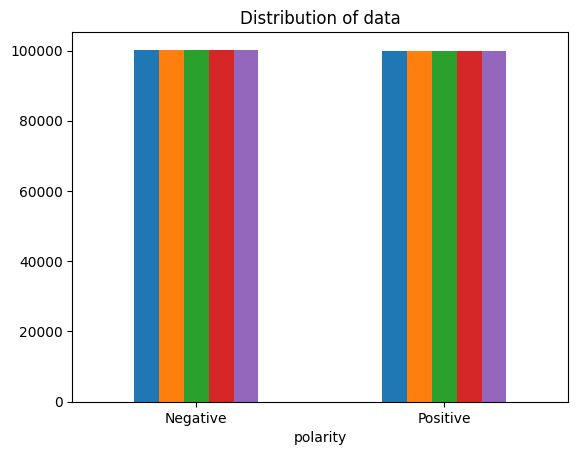

In [14]:
# Plotting the distribution for dataset.
ax = data.groupby('polarity').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [15]:
def word_count(words):
  return len(words.split())

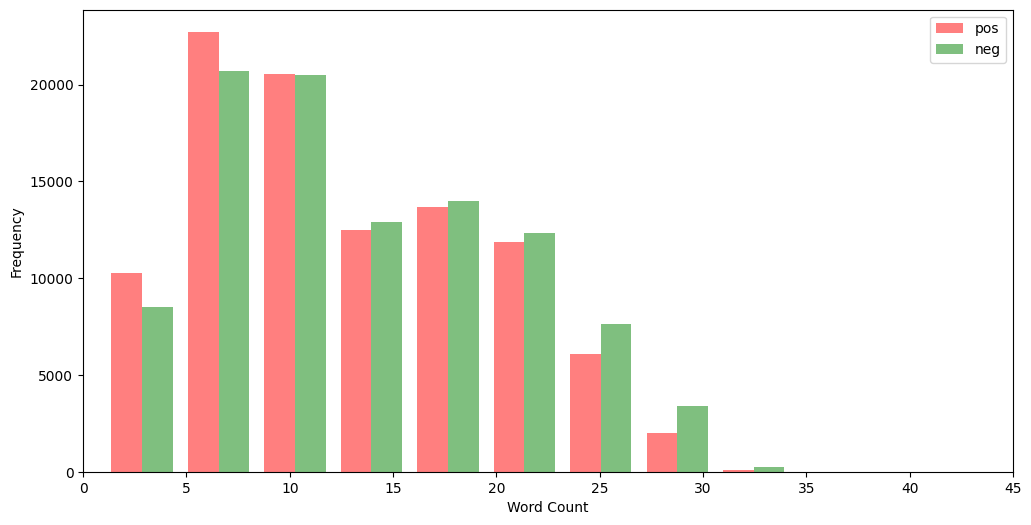

In [16]:
data['word_count'] = data['text'].apply(word_count)
p = data['word_count'][data.polarity == 1]
n = data['word_count'][data.polarity == 0]

plt.figure(figsize=(12, 6))
plt.xlim(0, 45)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
g = plt.hist([p,n], color = ['r', 'g'], alpha = 0.5, label=['pos', 'neg'])
plt.legend(loc = 'upper right')

# Data Pre-processing

In [17]:
from collections import Counter
all_words = []
for line in list(data['text']):
  words = line.split()
  for word in words:
    if(len(word)>2):
      all_words.append(word.lower())

Counter(all_words).most_common(20)

[('the', 64784),
 ('and', 37098),
 ('you', 29671),
 ('for', 26703),
 ('have', 17989),
 ('that', 15989),
 ("i'm", 15828),
 ('but', 15560),
 ('just', 15464),
 ('with', 14306),
 ('was', 12835),
 ('not', 12796),
 ('this', 11006),
 ('get', 10152),
 ('good', 9754),
 ('are', 9431),
 ('like', 9424),
 ('all', 9211),
 ('out', 8735),
 ('your', 8233)]

In [18]:
# Removing the unnecessary columns.
# data.drop(['date', 'query', 'user', 'word count'], axis=1, inplace = True)
# data.drop('id', axis=1, inplace = True)
data = data[['polarity','text']]

In [19]:
data.head()

,polarity,text
1009105,1,@OldPostcards Thanks for the thoughts - now th...
501043,0,Just got back from a funeral for an old friend...
105584,0,On Travelocity looking for some cheap flights ...
845800,1,"I`m at school, it`s boring....!"
1429303,1,@booklover28212 No...I think it appeared in th...


In [20]:
# calculate the null percentage
( data.isnull().sum() / len(data) )*100

polarity    0.0
text        0.0
dtype: float64

In [21]:
data['text'] = data['text'].astype('str')

In [22]:
! pip install nltk

In [23]:
import nltk
from nltk.corpus import stopwords

In [24]:
nltk.download('stopwords')
stopword_list = stopwords.words('english')

stopword_set = set(stopword_list)

print(stopword_set)

{'over', 'aren', 'didn', 'through', 'for', 'their', 'what', 'and', 'y', 'during', 'who', 'himself', 'yourself', 'but', "shouldn't", 'by', 'doesn', 'have', "hasn't", "couldn't", "don't", "weren't", 'was', 'myself', "isn't", 'her', 'or', "should've", 'shan', 'all', 'ain', 'on', 'themselves', 'weren', "she's", 'now', 'the', 'too', 'that', 'this', 'had', 'he', 'once', 'down', 'needn', 'an', 'hers', 'were', 'has', 'should', 'where', 'up', 'under', 'its', 'm', 'there', 'those', 're', 'of', 'shouldn', 'not', 'is', 'i', 'before', 'why', 'am', 'been', 'if', 'at', 'do', 'herself', 'it', 'ours', 'some', 'because', 'off', 'from', 'ma', 'these', 'won', 'both', 'while', 'out', 'be', 'are', "it's", 'couldn', 'a', 'against', 'they', 'o', 'don', 't', 'again', "you've", 'doing', 'so', "hadn't", 'him', 'isn', 'mustn', 'she', 'does', 'did', 'wouldn', "you're", "you'll", 'same', 'we', 'nor', 'as', 'which', 'haven', 'about', 'hasn', "wasn't", "wouldn't", 'no', "needn't", "shan't", 'further', 'below', 'me', 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [26]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
alphaPattern = "[^a-zA-Z0-9]"

def process_tweet(tweet):
  tweet = tweet.lower()
  tweet = tweet[1:]

  #Replace all URls
  tweet = re.sub(urlPattern,'',tweet)
  #Removing all userName
  tweet = re.sub(userPattern, '', tweet)
  #Remove punctuations
  tweet = tweet.translate(str.maketrans("","", string.punctuation))
  #tokenizing words
  tokens = word_tokenize(tweet)
  #Removing stop words
  final_tokens = [w for w in tokens if w not in stopword_set]
  #reducing a word to its word stem
  wordLem = WordNetLemmatizer()
  finalWords = []
  for w in final_tokens:
    if len(w) > 1:
      word = wordLem.lemmatize(w)
      finalWords.append(word)
  return ' '.join(finalWords)

In [27]:
data['preprocessed_tweets'] = data['text'].apply(lambda x: process_tweet(x))
print("Text pre-processing is done]")

Text pre-processing is done]


In [28]:
data.head()

,polarity,text,preprocessed_tweets
1009105,1,@OldPostcards Thanks for the thoughts - now th...,oldpostcards thanks thought wait result begin
501043,0,Just got back from a funeral for an old friend...,ust got back funeral old friend hate thing gue...
105584,0,On Travelocity looking for some cheap flights ...,travelocity looking cheap flight buffalo ny li...
845800,1,"I`m at school, it`s boring....!",school boring
1429303,1,@booklover28212 No...I think it appeared in th...,booklover28212 noi think appeared late 90 go w...


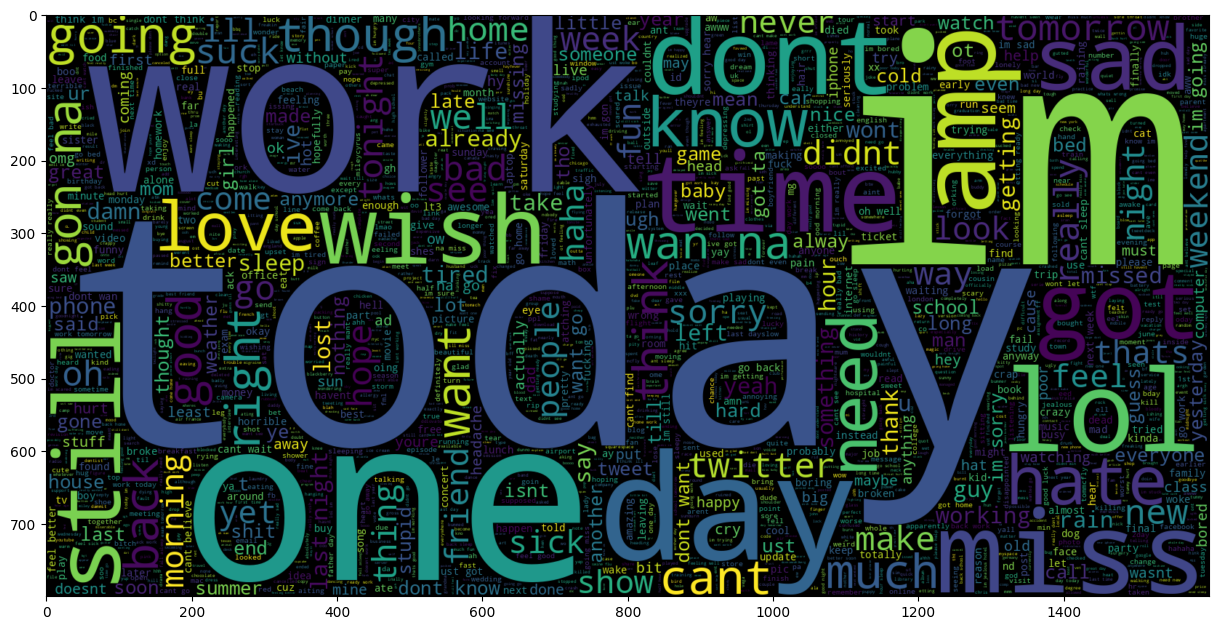

In [29]:
#negative tweets
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(data[data.polarity == 0].preprocessed_tweets))
plt.imshow(wc, interpolation='bilinear')

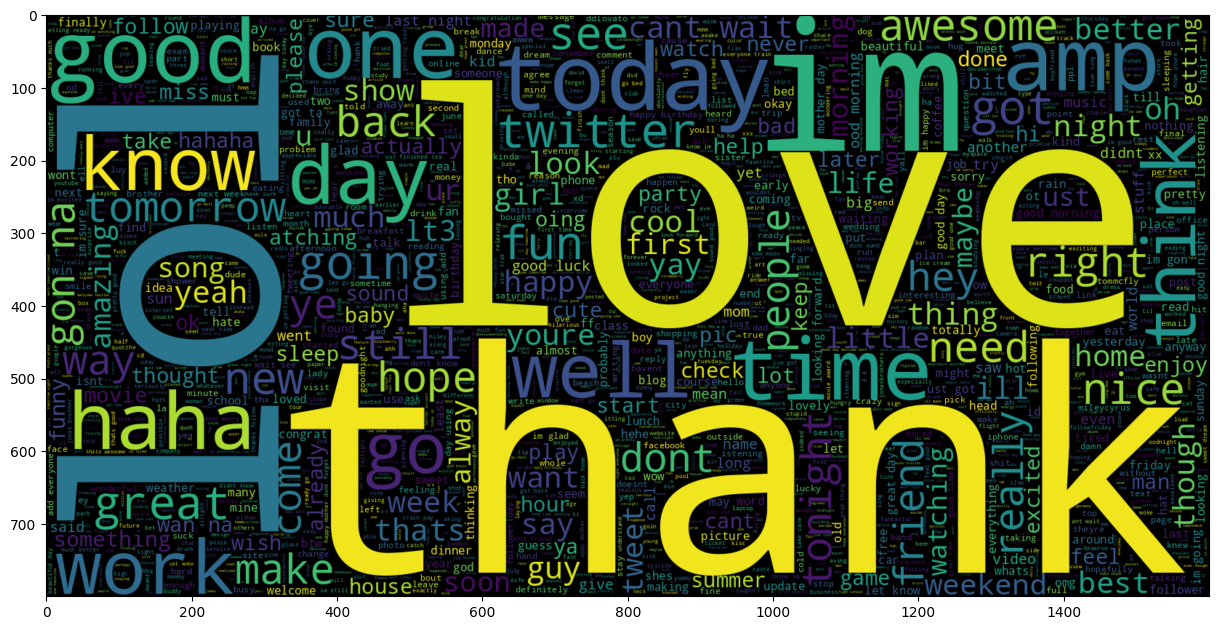

In [30]:
#positive tweets
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(data[data.polarity == 1].preprocessed_tweets))
plt.imshow(wc, interpolation='bilinear')

In [31]:
x = data['preprocessed_tweets'].values
y = data['polarity'].values

In [32]:
print(x.shape)
print(y.shape)

(200000,)
(200000,)


In [33]:
vectorizer = TfidfVectorizer(sublinear_tf=True)
X = vectorizer.fit_transform(x)
print(f'vectorizer fitted.')
print('No. of feature_words: ', len(vectorizer.get_feature_names_out()))

vectorizer fitted.
No. of feature_words:  170243


In [34]:
print(X.shape)

(200000, 170243)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.20, random_state = 101)

In [36]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("X_test", X_test.shape)
print("y_test", y_test.shape)


X_train (160000, 170243)
y_train (160000,)

X_test (40000, 170243)
y_test (40000,)


# Accuracy for Models(LogisticRegression, SVM, RandomForest, and NaiveBayes)

In [37]:
def model_evaluation(model):
  # accuracy of model on training data
  acc_train = model.score(X_train, y_train)
  # accuracy of model on test data
  acc_test = model.score(X_test, y_test)

  print('Accuracy of the model on train data: {}'.format(acc_train*100))
  print('Accuracy of the model on test data: {}'.format(acc_test*100))

  # Predect test data
  y_pred = model.predict(X_test)

  # Print the Evaluation metrics for the dataset
  print(classification_report(y_test, y_pred))

  # Compute confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)

  categories = ['Negative', 'Positive']
  group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
  group_percentages = [ '{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '', xticklabels = categories, yticklabels = categories)

  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**Logistic Regression**

Accuracy of the model on train data: 83.403125
Accuracy of the model on test data: 76.86500000000001
              precision    recall  f1-score   support

           0       0.79      0.74      0.76     20173
           1       0.75      0.80      0.77     19827

    accuracy                           0.77     40000
   macro avg       0.77      0.77      0.77     40000
weighted avg       0.77      0.77      0.77     40000



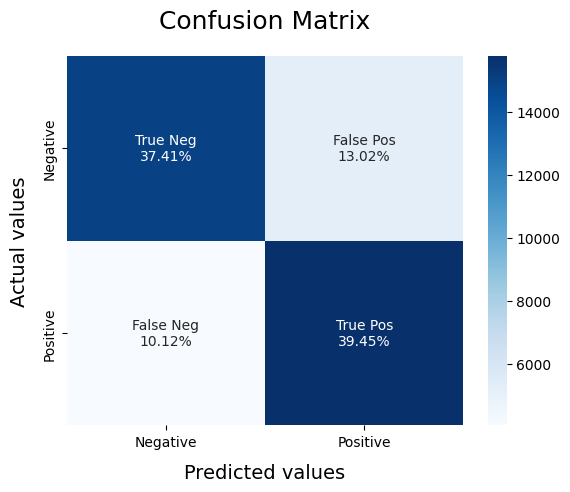

In [38]:
lg = LogisticRegression()
history = lg.fit(X_train, y_train)
model_evaluation(lg)

**Linear SVC**

Accuracy of the model on train data: 93.014375
Accuracy of the model on test data: 75.815
              precision    recall  f1-score   support

           0       0.77      0.74      0.76     20173
           1       0.75      0.78      0.76     19827

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



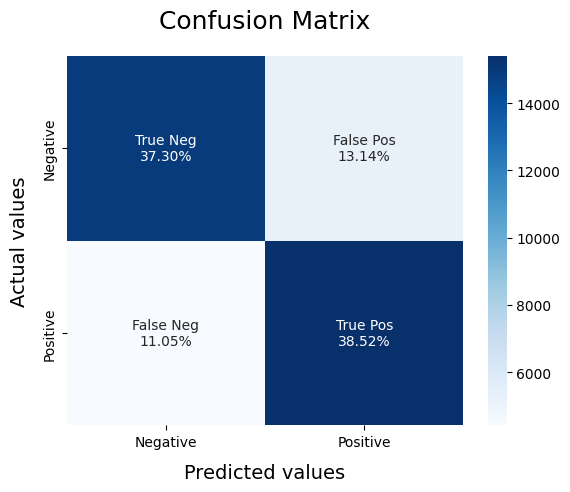

In [39]:
svm = LinearSVC()
svm.fit(X_train, y_train)
model_evaluation(svm)

**naive_bayes**

Accuracy of the model on train data: 86.773125
Accuracy of the model on test data: 75.6525
              precision    recall  f1-score   support

           0       0.75      0.78      0.76     20173
           1       0.76      0.74      0.75     19827

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



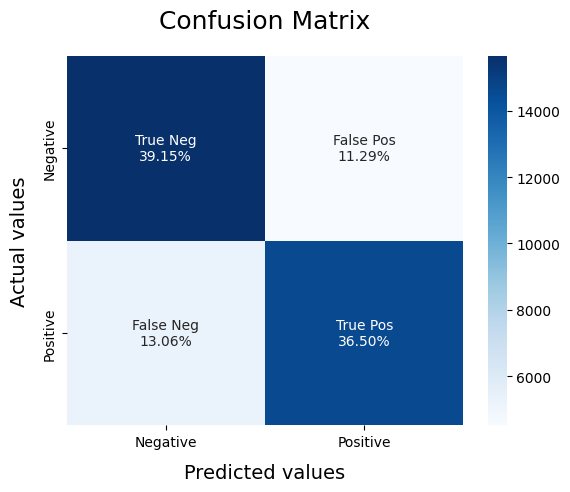

In [40]:
nb = BernoulliNB()
nb.fit(X_train, y_train)
model_evaluation(nb)

**Random Forest Classifier**

Accuracy of the model on train data: 75.691875
Accuracy of the model on test data: 70.8075
              precision    recall  f1-score   support

           0       0.74      0.66      0.69     20173
           1       0.68      0.76      0.72     19827

    accuracy                           0.71     40000
   macro avg       0.71      0.71      0.71     40000
weighted avg       0.71      0.71      0.71     40000



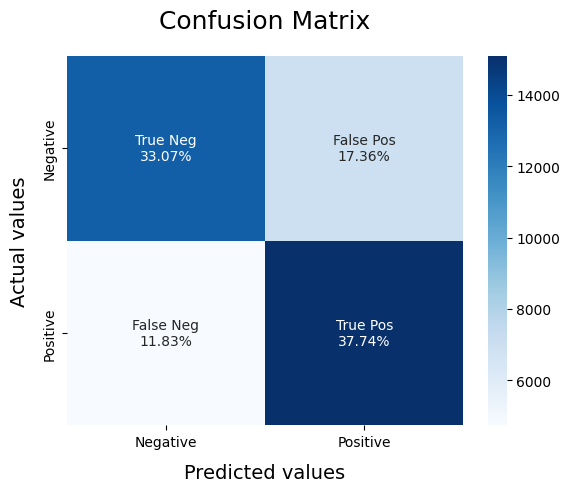

In [41]:
rfc = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', max_depth=50)
rfc.fit(X_train, y_train)
model_evaluation(rfc)

# RNN

In [46]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical


In [47]:
import keras
keras.__version__

'2.15.0'

In [50]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(data.preprocessed_tweets)
sequences = tokenizer.texts_to_sequences(data.preprocessed_tweets)
tweets = pad_sequences(sequences, maxlen = max_len)
print(tweets)

[[   0    0    0 ...   68 1025 1230]
 [   0    0    0 ...  197 3569 4294]
 [   0    0    0 ...   92  207  260]
 ...
 [   0    0    0 ...    3    6 2251]
 [   0    0    0 ...  365  336 2844]
 [   0    0    0 ...    1  420 3010]]


In [51]:
X_train, X_test, y_train, y_test = train_test_split(tweets, data.polarity.values, test_size = 0.20, random_state = 101)

In [53]:
from keras import layers
from keras import backend as k
from keras.callbacks import ModelCheckpoint

RNNmodel = Sequential()
RNNmodel.add(layers.Embedding(max_words, 128))
RNNmodel.add(layers.LSTM(64, dropout=0.5))
RNNmodel.add(layers.Dense(16, activation='relu'))
RNNmodel.add(layers.Dense(8, activation='relu'))
RNNmodel.add(layers.Dense(1, activation='sigmoid'))
RNNmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint2 = ModelCheckpoint("rnn_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only= True, mode='auto', period=1)
history = RNNmodel.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test),callbacks=[checkpoint2])



Epoch 1/10
5000/5000 [==============================] - ETA: 0s - loss: 0.5101 - accuracy: 0.7469
Epoch 1: val_accuracy improved from -inf to 0.76720, saving model to rnn_model.hdf5
5000/5000 [==============================] - 874s 174ms/step - loss: 0.5101 - accuracy: 0.7469 - val_loss: 0.4830 - val_accuracy: 0.7672
Epoch 2/10
5000/5000 [==============================] - ETA: 0s - loss: 0.4683 - accuracy: 0.7747
Epoch 2: val_accuracy improved from 0.76720 to 0.77035, saving model to rnn_model.hdf5
5000/5000 [==============================] - 851s 170ms/step - loss: 0.4683 - accuracy: 0.7747 - val_loss: 0.4801 - val_accuracy: 0.7703
Epoch 3/10
5000/5000 [==============================] - ETA: 0s - loss: 0.4522 - accuracy: 0.7837
Epoch 3: val_accuracy improved from 0.77035 to 0.77200, saving model to rnn_model.hdf5
5000/5000 [==============================] - 955s 191ms/step - loss: 0.4522 - accuracy: 0.7837 - val_loss: 0.4768 - val_accuracy: 0.7720
Epoch 4/10
5000/5000 [===============

In [54]:
sequence = tokenizer.texts_to_sequences(['this course is excellent and offers many features.'])
test = pad_sequences(sequence, maxlen=max_len)
pred = RNNmodel.predict(test)
if pred > 0.5:
  print('positive')
else:
  print('negative')


1/1 [==============================] - 1s 546ms/step
positive


In [69]:
model = keras.models.load_model('rnn_model.hdf5')
sequence = tokenizer.texts_to_sequences(['Always this is mad idea'])
test = pad_sequences(sequence, maxlen=max_len)
pred = model.predict(test)
if pred > 0.5:
  print('positive')
else:
  print('negative')

1/1 [==============================] - 2s 2s/step
negative


# Evaluation ML models

Save ML models as pickle file. It serializes a vectorizer, LogisticRegression, SVM, RandomForest, and NaiveBayes models into respective .pickle files for later use.

In [60]:
import pickle

file = open('vectoriser.pickle', 'wb')
pickle.dump(vectorizer, file)
file.close()

file = open('logisticRegression.pickle', 'wb')
pickle.dump(lg, file)
file.close()

file = open('SVM.pickle', 'wb')
pickle.dump(svm, file)
file.close()

file = open('RandomForest.pickle', 'wb')
pickle.dump(rfc, file)
file.close()

file = open('NaivesBayes.pickle', 'wb')
pickle.dump(nb, file)
file.close()

Logistic Regression is best test accuracy than SVM, naive_bayes, Random Forest. So evaluate the logistic regression

In [61]:
def load_models():
  file = open('vectoriser.pickle', 'rb')
  vectoriser = pickle.load(file)
  file.close()

  file = open('logisticRegression.pickle', 'rb')
  lg = pickle.load(file)
  file.close()

  return vectoriser, lg

In [62]:
def predict(vectoriser, model, text):
  process_text = [process_tweet(sen) for sen in text]
  textdata = vectoriser.transform(process_text)
  sentiment = model.predict(textdata)

  data =[]
  for text, pred in zip(text, sentiment):
    data.append((text,pred))

  df = pd.DataFrame(data, columns = ['text', 'sentiment'])
  df = df.replace([0,1], ['Negative', 'Positive'])
  return df

In [65]:
if __name__ == "__main__":
  vectoriser, lg = load_models()

  text = ['I love machine learning', 'work is narrow', 'Ravi, I feel so good']

  df = predict(vectoriser, lg, text)
  print(df.head())

                      text sentiment
0  I love machine learning  Positive
1           work is narrow  Negative
2     Ravi, I feel so good  Positive
